# Day 5: Introduction to Python

### by Justin B. Kinney

As always, do this first

In [1]:
# Always put this first
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Today we will load data from a DNA replicaiton profiling experiment, smooth read counts along the genome, and plot the resulting replication profiles. This will give us a chance to use one of the most useful python modules out there: **pandas**

In [2]:
# Clean current directory and list files
# WARNING: won't work on Windows Machines
!rm *.pdf *.png
!ls -lah

rm: *.pdf: No such file or directory
rm: *.png: No such file or directory
total 78192
drwxr-xr-x   9 jkinney  staff   306B Jul 19 17:11 .
drwxr-xr-x  10 jkinney  staff   340B Jul 19 12:55 ..
drwxr-xr-x   3 jkinney  staff   102B Jul 19 12:56 .ipynb_checkpoints
-rw-------@  1 jkinney  staff   8.7M Nov  7  2011 A1.pileup.bed
-rw-------@  1 jkinney  staff   8.7M Nov  7  2011 B1.pileup.bed
-rw-------@  1 jkinney  staff   8.7M Nov  8  2011 C1.pileup.bed
-rw-------   1 jkinney  staff   8.7M Jul 19 13:53 D1.pileup.bed
-rw-r--r--@  1 jkinney  staff   3.5M Jul 19 16:28 EdU_pulldown_experiment.key
-rwx------@  1 jkinney  staff    16K Jul 19 17:11 day5.ipynb


The files we want are the X1.pileup.bed files. Let's use 'cat' to see what these files look like

In [3]:
# Warning: won't work on Windows machines
!head A1.pileup.bed

browser position chrIV:1-1531933
track type=bedGraph visibility=2 name="A1" description="A1"
chrI	1	31	2	
chrI	32	62	0	
chrI	63	93	1	
chrI	94	124	0	
chrI	125	155	3	
chrI	156	186	0	
chrI	187	217	0	
chrI	218	248	0	


This is a tab-delimited text file. This is exactly the kind of file that pandas is designed to work with. Let's open the file up using pandas

In [4]:
# Read file into a pandas "data frame"
df = pd.read_csv('A1.pileup.bed',  
                 names=['chromosome','start','stop','reads'], 
                 delim_whitespace=True, 
                 skiprows=2)

In [5]:
# Check the size of the dataframe
df.shape

(389384, 4)

In [6]:
# Check the first 5 rows of the dataframe
df.head()

,chromosome,start,stop,reads
0,chrI,1,31,2
1,chrI,32,62,0
2,chrI,63,93,1
3,chrI,94,124,0
4,chrI,125,155,3


In [7]:
# Check the last 5 rows of the dataframe
df.tail()

,chromosome,start,stop,reads
389379,chrXVI,947888,947918,6
389380,chrXVI,947919,947949,4
389381,chrXVI,947950,947980,8
389382,chrXVI,947981,948011,7
389383,chrXVI,948012,948042,13


In [8]:
# Extract a value from the table 
value = df.loc[0,'reads']
print 'value at row 0, column "start" is', value
print 'This value is a', type(value)

value at row 0, column "start" is 2
This value is a <type 'numpy.int64'>


In [9]:
# Extract a value by numerical location
value = df.iloc[0,3]
print 'value at row number 0, column number 3 is', value
print 'This value is a', type(value)

value at row number 0, column number 3 is 2
This value is a <type 'numpy.int64'>


In [10]:
# Extract a column
col = df.loc[:,'reads']
print 'col an %s object of length %d'%(type(col),len(col))
print 'The first 5 elements are\n', col[:5]

col an <class 'pandas.core.series.Series'> object of length 389384
The first 5 elements are
0    2
1    0
2    1
3    0
4    3
Name: reads, dtype: int64


In [11]:
# Convert a Series into a numpy array
col_narray = col.values
print 'col_narray an %s object of length %d'%(type(col_narray),len(col_narray))
print 'The first 5 elements are', col_narray[:5]

col_narray an <type 'numpy.ndarray'> object of length 389384
The first 5 elements are [2 0 1 0 3]


In [12]:
# Extract values for chromosome IV only. 
chrom_we_want = 'chrIV'
indices = df.loc[:,'chromosome']==chrom_we_want
chr4_df = df.loc[indices,:]
print 'chr4_df has %d rows'%len(chr4_df)
chr4_df.head()

chr4_df has 49417 rows


,chromosome,start,stop,reads
43869,chrIV,1,31,0
43870,chrIV,32,62,1
43871,chrIV,63,93,1
43872,chrIV,94,124,1
43873,chrIV,125,155,0


In [13]:
# Compute read length
read_length = df.loc[0,'stop'] - df.loc[0,'start'] + 1
print read_length

31


Now let's plot these number of reads across the chromosome.

In [21]:
# Extract vectors of starts, stops, and number of reads
starts = chr4_df.loc[:,'start'].values
stops = chr4_df.loc[:,'stop'].values
num_reads = chr4_df.loc[:,'reads'].values

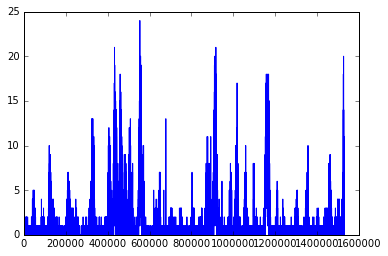

In [22]:
# Plot the starts
plt.plot(starts, num_reads)

Well, this kinda looks right. But we're too far away to see what's going on well. Let's zoom in

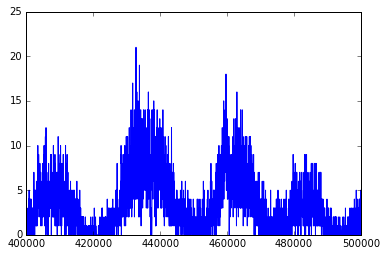

In [23]:
# Zoom in to region between 400K and 500k
zoom_indices = (starts > 4E5) & (starts < 5E5)
plt.plot(starts[zoom_indices], num_reads[zoom_indices])

It's becomming clear that, in order to make sense of this data, we're going to need to smooth it. How do we do that? Fortunately, SciPy contains tons of routines for signal processing like this. 

In [27]:
# Create a "kernel" with which to smooth the data
# from experience, 6 kb is a nice window size
window_bp = 6000
read_length = 31
window_size = window_bp//read_length
print window_size

193


In [28]:
# Create a window kernel so that all elements sum to 1
window = np.ones(window_size)/window_size

# Make sure that the 
sum(window)

1.0000000000000024

In [29]:
from scipy.signal import convolve

# Smooth the data by convolving (not convoluting!) the window with the read counts
smooth_reads = convolve(num_reads,window,'same')

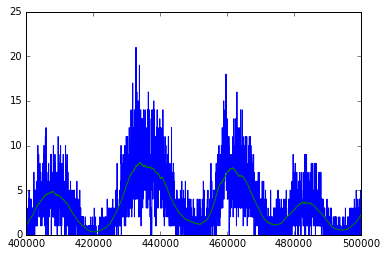

In [30]:
plt.plot(starts[zoom_indices], num_reads[zoom_indices])
plt.plot(starts[zoom_indices], smooth_reads[zoom_indices])

Hm, this is a bit hard to see. Let's clairfy the plot.

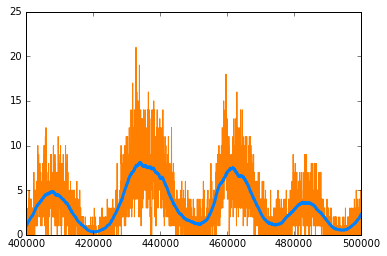

In [31]:
orange = [1, .5, 0]
lightblue = [0, .5, 1]
plt.plot(starts[zoom_indices], num_reads[zoom_indices], color=orange)
plt.plot(starts[zoom_indices], smooth_reads[zoom_indices], color=lightblue, linewidth=3)

Great. Now let's make a chromosome-wide replication profile. Let's also put a little effort into making it look pretty. 

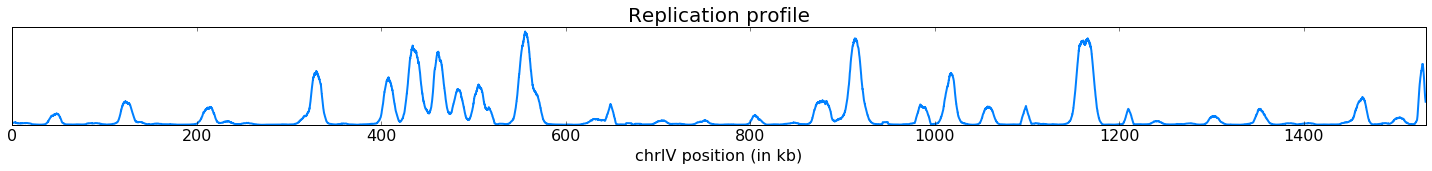

In [32]:
# Choose our color
lightblue = [0, .5, 1]

# Easier to discuss genomic positions in kb
kb = 1E3
x = 0.5*(starts+stops)/kb
L = max(x)

figure_size = [20,2.5]
label_size = 16
title_size = 20
plt.figure(figsize=figure_size)

# Plot
plt.plot(x, smooth_reads, color=lightblue, linewidth=2)

# Place tick marks on x axis ever 200 kb
plt.xticks(np.arange(0,L,200), fontsize=label_size)

# Fit plot to precisely the width of the chromosome
plt.xlim([min(x), max(x)])

# No need to show ticks on the y axes
plt.yticks([])

# Add some text annotation, telling the user
plt.title('Replication profile', fontsize=title_size)
plt.xlabel(chrom_we_want + ' position (in kb)', fontsize=label_size)

# Fix spacing
plt.tight_layout()

file_name = 'profile_for_%s.png'%chrom_we_want
plt.savefig(file_name)

plt.show()

Great! With this smoothed data we can go ahead and identify peaks in the replicaiton profile, measure their width, height, etc. 

In [33]:
# WARNING: Won't work on windows machines
!ls -lah

total 78488
drwxr-xr-x  10 jkinney  staff   340B Jul 19 17:53 .
drwxr-xr-x  10 jkinney  staff   340B Jul 19 12:55 ..
drwxr-xr-x   3 jkinney  staff   102B Jul 19 12:56 .ipynb_checkpoints
-rw-------@  1 jkinney  staff   8.7M Nov  7  2011 A1.pileup.bed
-rw-------@  1 jkinney  staff   8.7M Nov  7  2011 B1.pileup.bed
-rw-------@  1 jkinney  staff   8.7M Nov  8  2011 C1.pileup.bed
-rw-------   1 jkinney  staff   8.7M Jul 19 13:53 D1.pileup.bed
-rw-r--r--@  1 jkinney  staff   3.5M Jul 19 16:28 EdU_pulldown_experiment.key
-rwx------@  1 jkinney  staff   133K Jul 19 17:53 day5.ipynb
-rw-r--r--   1 jkinney  staff    29K Jul 19 17:52 profile_for_chrIV.png


In [34]:
!open $file_name

Now let's write a function that will load and smooth the profile from any chromosome we want

In [35]:
import os.path 

def load_and_smooth_profile(file_name, chrom_we_want, window_bp=6000):
    """
    Load a smooth a replication profile.
    
    Arguments:
        file_name -- name of a bed file containing the data
        chrom_we_want -- chromosome name in Roman numerals: chrI, ..., chrXVI
        window_bp -- length of smoothing window in bp
    
    Returns:
        centers -- location of bin centers along the chromosome
        smooth_reads -- smoothed number of reads in each bin
    """
   
    # Check validity of file
    assert isinstance(file_name,str), 'file_name is not a string.'
    assert os.path.isfile(file_name), 'file %s does not exist'%file_name
    
    # Read file into dataframe 
    df = pd.read_csv(file_name,  
                 names=['chromosome','start','stop','reads'], 
                 delim_whitespace=True, 
                 skiprows=2)
    
    # Check validity of chromosome
    assert isinstance(chrom_we_want,str), 'chrom_we_want is not a string'
    assert chrom_we_want in df.loc[:,'chromosome'].values, 'chrom_we_want value %s not found in data frame.'%chrom_we_want
        
    # Check validity of window_bp
    assert isinstance(window_bp, int), "window_bp is not an integer."
    assert window_bp > 0, "nonpositive window_bp value of %d"%window_bp
    
    # Choose rows to look at
    indices = df['chromosome']==chrom_we_want
    
    # Extract read_lenght, num_reads and centers
    chr_df = df.loc[indices,:]
    num_reads = chr_df.loc[:,'reads'].values
    starts = chr_df.loc[:,'start'].values
    stops = chr_df.loc[:,'stop'].values
    centers = 0.5*(starts + stops)
    
    # Create convolution window
    read_length = df.loc[0,'stop'] - df.loc[0,'start'] + 1
    window_size = window_bp//read_length
    window = np.ones(window_size)/window_size
    
    # Smooth read counts
    smooth_reads = convolve(num_reads,window,'same')
    
    # Now return results
    return centers, smooth_reads

In [36]:
def plot_profile(centers, 
                 smooth_reads,  
                 title='', 
                 kbspacing=200, 
                 color=[0, .5, 1]):
    """
    Plot a replication profile
    
    Arguments:
        centers -- numpy array of bin locations
        smooth_reads -- numpy array of smoothed read counts; same length as centers
        title -- title for plot
        kbspacing -- tick mark spaking in kilobases
        color -- color of plot
    """
    
    assert len(centers)==len(smooth_reads), "centers and smooth_reads are not the same length."
    assert isinstance(title,str), "title is not a string"
    assert isinstance(kbspacing,int), "kbspacing is not an int"
    assert kbspacing > 0, "nonpositive kbspacing value of %d"%kbspacing
    
    # Easier to discuss genomic positions in kb
    kb = 1E3
    x = centers/kb
    L = max(x)
    
    label_size = 16
    title_size = 20
    
    # Plot
    plt.plot(x, smooth_reads, color=color, linewidth=2)
    
    # Place tick marks on x axis ever 200 kb
    plt.xticks(np.arange(0,L,kbspacing), fontsize=label_size)
    
    # Fit plot to precisely the width of the chromosome
    plt.xlim([min(x), max(x)])
    
    # No need to show ticks on the y axes
    plt.yticks([])
    
    # Add some text annotation, telling the user
    plt.title(title, fontsize=title_size)
    plt.xlabel('position (in kb)', fontsize=label_size)
    

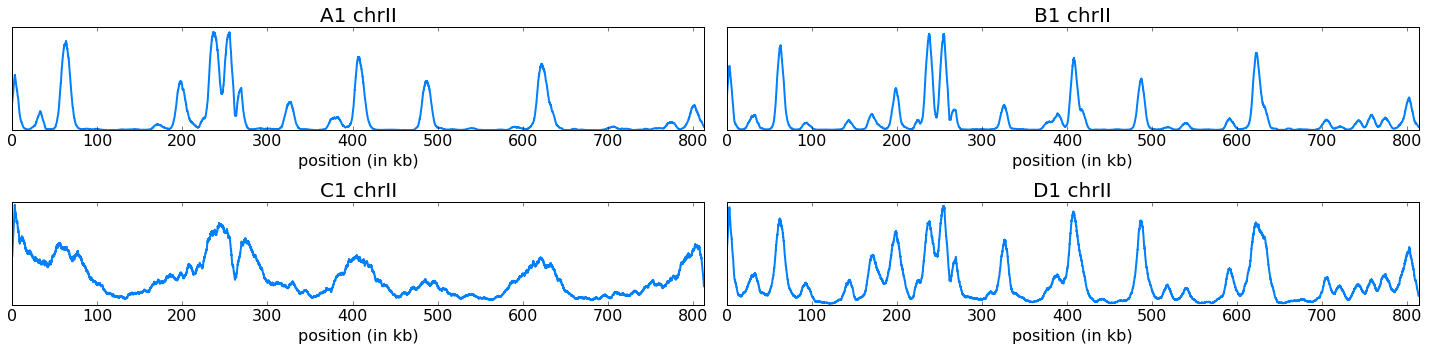

In [37]:
# Plot 4 replication profiles
plt.figure(figsize=[20,5])

# Chromosome to focus on
chrom_we_want = 'chrII'

# Names of samples
samples = ['A1','B1','C1','D1']

# Look over each sample
for num, name in enumerate(samples):

    # Smooth profile
    file_name = '%s.pileup.bed'%name
    ctrs, rds = load_and_smooth_profile(file_name, chrom_we_want)
    
    # Plot profile
    plt.subplot(2,2,num+1)
    title = '%s %s'%(name,chrom_we_want)
    plot_profile(ctrs, rds, title=title, kbspacing=100)

# Fix layout
plt.tight_layout()

# Save 
plt.savefig('%s_all_samples.pdf'%chrom_we_want)

# Show plot
plt.show()

In [38]:
# Open figure in another applicaiton
# WARNING: won't work on Windows Machines
!open *_all_samples.pdf

Done.